### EDA+: make 'trivial predictions' to get a baseline

(for basic EDA, see this kernel: https://www.kaggle.com/rpeer333/molecular-properties-detailed-eda)

After EDA but efore starting to build models, it makes sense to get an idea, how large the loss would when making trivial predictions, such as:

* always predicting the median
* only using the distance between the j-coupled atoms for (univariate) regression
* always prediting the median per type of j-coupling
* etc.

Only features that are already available easy to compute are used for this purpose to get an idea of their relatlive importance.

It also establishes a base-line: Any model that is not way better than these trivial predictions is clearly not working and it's time to move on to the next idea.

In [1]:
import os
from os.path import join

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.linear_model import LinearRegression

In [2]:
DATA_DIR = '../input/champs-scalar-coupling'
train_all = pd.read_csv(join(DATA_DIR, 'train.csv'))
test = pd.read_csv(join(DATA_DIR, 'test.csv'))
structures = pd.read_csv(join(DATA_DIR, 'structures.csv'))

# Add simple features

In [3]:
def map_atom_info(df, atom_idx, structures_df=structures):
    """
    From this kernel:
    https://www.kaggle.com/seriousran/just-speed-up-calculate-distance-from-benchmark
    """
    df = pd.merge(df, structures_df, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df


train_all = map_atom_info(train_all, 0)
train_all = map_atom_info(train_all, 1)

test = map_atom_info(test, 0)
test = map_atom_info(test, 1)

train_all.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,H,-0.523814,1.437933,0.906397
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001


In [4]:
# code in this cell is from:
# https://www.kaggle.com/rpeer333/brute-force-feature-engineering/edit

train_p_0 = train_all[['x_0', 'y_0', 'z_0']].values
train_p_1 = train_all[['x_1', 'y_1', 'z_1']].values
test_p_0 = test[['x_0', 'y_0', 'z_0']].values
test_p_1 = test[['x_1', 'y_1', 'z_1']].values

train_all['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
test['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)

In [5]:
def add_sc_type_features(df, one_hot=False):
    assert 'type' in df.columns
    
    df['bonds']    = df.type.map(lambda x: int(x[0]))
    df['atom_pair'] = df.type.map(lambda x: x[2:4])
    
    if one_hot:
        df = pd.get_dummies(df, prefix='bonds')
        df = pd.get_dummies(df, prefix='atom_pair')
    
    return df


train_all = add_sc_type_features(train_all)
test  = add_sc_type_features(test)
train_all.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dist,bonds,atom_pair
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001,1.091953,1,HC
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277,1.783120,2,HH
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644,1.783147,2,HH
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,H,-0.523814,1.437933,0.906397,1.783157,2,HH
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001,1.091952,1,HC


# Split into training and validation-set

In [6]:
is_train = np.random.rand(len(train_all)) < 0.8

val   = train_all[~is_train].copy()
train = train_all[is_train].copy()
print(f'training-fraction: {len(train) / (len(train) + len(val)):.4f}')

training-fraction: 0.8001


## Context:

#### From Competition description:
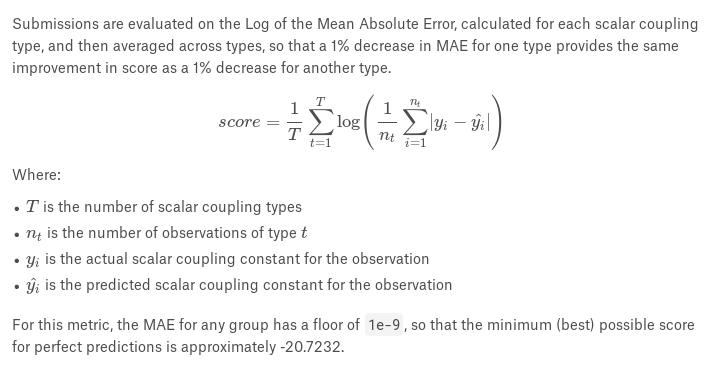

Best current score: -2.975  
Current medal-score: <= -1.566

#### Type-weights

Note that the MAEs for all 8 types of sc are weighted equally regadless of their (very differnt) frequencies in the data-set.

The trivial predictions could probably be improved by simply adding weights to the data points such that the sum of weights for each of the 8 types is exactly 1/8.

In [7]:
def metric(df, preds):
    """
    function from: https://www.kaggle.com/abhishek/competition-metric
    """
    
    df["prediction"] = preds
    maes = []
    for t in df.type.unique():
        y_true = df[df.type==t].scalar_coupling_constant.values
        y_pred = df[df.type==t].prediction.values
        mae = np.log(metrics.mean_absolute_error(y_true, y_pred))
        maes.append(mae)
        
    return np.mean(maes)

# Predict median sc-constant

We use the median rather than the mean because the comptetion metric is based on the mean absolute error which is minimized by the median (the arithemtic mean would minimize the the mean squared error).

In [8]:
median_prediction = np.tile(train.scalar_coupling_constant.median(), len(val))
metric(val, median_prediction)

1.99404057751622

In [9]:
mean_prediction = np.tile(train.scalar_coupling_constant.mean(), len(val))
metric(val, mean_prediction)

3.0076632926988136

# Predict median sc-constant for each type

The range of sc-constants varies from type to type. Therefore, predicting the median per type will give better results than simply predicting the global median.



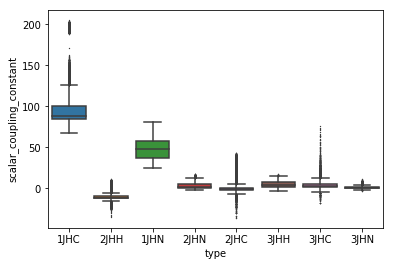

In [10]:
sns.boxplot(data=train, x='type', y='scalar_coupling_constant', fliersize=0.5);

In [11]:
group_medians = train.groupby('type').apply(lambda df: df.scalar_coupling_constant.median())
group_medians

type
1JHC    88.217100
1JHN    47.675100
2JHC    -0.950913
2JHH   -11.327100
2JHN     2.000100
3JHC     2.883350
3JHH     3.689215
3JHN     0.658687
dtype: float64

In [12]:
group_median_prediction = val.type.map(group_medians)
type_median_score = metric(val, group_median_prediction)
type_median_score

1.1868979225635863

# Linear Regression on euclidean distance

Interestingly regression on the distance between atom-0 and atom-1 is only barely better than the predicting the mean (which is equivalent to 'fitting' the best regression line with zero slope).

In [13]:
lin_reg = LinearRegression()
lin_reg.fit(X=np.reshape(train.dist.values, (-1, 1)),
            y=train.scalar_coupling_constant.values)
y_hat = lin_reg.predict(np.reshape(val.dist.values, (-1, 1)))

metric(val, y_hat)

2.8765896067452155

# Linear regression on distance and sc-type indicator-varibles

Interestinly, this model is even worse than the per-type-median prediction. Probably due to the fact that linear regression minimizes the mean squared error rather than the mean absolute error used in the competition metric.

In [14]:
X_train = pd.get_dummies(train[['dist', 'type']], prefix='type', drop_first=True).values
X_val   = pd.get_dummies(val[['dist', 'type']], prefix='type', drop_first=True).values

lin_reg = LinearRegression()
lin_reg.fit(X=X_train, y=train.scalar_coupling_constant.values)
y_hat = lin_reg.predict(X_val)

score = metric(val, y_hat)
print(f'score: {score}')
print(f'improvement over type-mean-prediction: {type_median_score - score}')

score: 1.2358006395426315
improvement over type-mean-prediction: -0.048902716979045247
